# Trajectory prediction (Lera) 


**Goal** : Thesis for Lera A

**Expected outcome:** 


## 1. Import 

In [1]:
import pandas as pd
import numpy as np 
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os

import tensorflow as tf

## 2. Read Data

In [2]:
sampleDf = pd.read_csv('Data/sample_0_1.csv', usecols=['roll_bt','roll_bb','yaw_lt','yaw_lb','yaw_rt','yaw_rb'])
sampleDf.head()

,roll_bt,roll_bb,yaw_lt,yaw_lb,yaw_rt,yaw_rb
0,-95.851903,-96.780939,3.986249,-1.302394,1.297816,-2.776453
1,-96.679724,-97.550099,2.833914,-2.907535,0.971096,-1.680133
2,-96.693771,-96.632356,3.737014,-2.348383,1.312592,-2.695344
3,-95.757090,-95.615713,3.282922,-2.602976,0.981812,-2.809867
4,-96.425966,-96.774876,3.482173,-3.955472,1.500795,-2.464036


## 3. Define model

In [3]:
import os
def get_train_data(wind_size = 15, target_feature='roll_bb'):
    Res_X = []
    Res_y = []
    for file in os.listdir('./Data'):
        temp_df = pd.read_csv(f'Data/{file}', usecols=[target_feature])
        Res_y += temp_df[target_feature].values[wind_size-1:].copy().tolist()
        temp_df[temp_df.columns] = MinMaxScaler((-1,1)).fit_transform(temp_df.values)
        for i in temp_df.rolling(wind_size):
            if i.shape[0] < wind_size: continue
            Res_X.append(i[target_feature].values.tolist())
    return np.expand_dims(np.array(Res_X),axis=1), np.array(Res_y)

## 4. Train Model

In [6]:
wind_size = 15

In [8]:
def make_model(wind_size=15):
    model = tf.keras.Sequential()

    # Add a SimpleRNN layer with 3 internal units.
    model.add(tf.keras.layers.SimpleRNN(15, return_sequences=True, activation='tanh'))
#     model.add(tf.keras.layers.SimpleRNN(10, activation='sigmoid'))

    # Add a Dense layer with 1 unit.
    model.add(tf.keras.layers.Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
    #model.summary()

[670.2808227539062, 670.1329956054688, 669.494384765625, 670.8078002929688, 665.0745239257812]


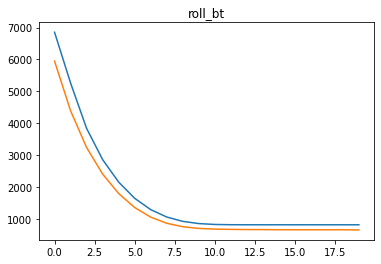

KeyboardInterrupt: 

In [9]:
for feature in sampleDf.columns:
    xtrain, ytrain = get_train_data(wind_size=wind_size, target_feature=feature)
    model = make_model(wind_size=wind_size)
    history = model.fit(xtrain, ytrain, epochs=20, batch_size=32, verbose=0, validation_split=0.3)
    
    plt.plot(np.arange(len(history.history.get('loss'))),history.history.get('loss'))
    plt.plot(np.arange(len(history.history.get('val_loss'))),history.history.get('val_loss'))
    print(history.history.get('val_loss')[-5:])
    plt.title(feature)
    plt.show()

## 5. Create an Ensemble model

In [ ]:
class EnsembleModel(object):
    """docstring for EnsembleModel."""

    def __init__(self, data_path, window_size=15):
        super(EnsembleModel, self).__init__()
        self.data_path = data_path
        xtrain, ytrain = None, None
        
    def read_data(self):
        pass
    
    def train(self):
        pass
    
    def test(self):
        pass
    
    def predict(self):
        pass

## 6. LSTM

In [10]:
def generate_data(X, y, sequence_length = 15, step = 1, scaler=None):
    X_local = []
    y_local = []
    for start in range(0, len(X) - sequence_length, step):
        end = start + sequence_length
        if scaler != None:
            X_local.append(scaler.transform(X[start:end]))
        else:
            X_local.append(X[start:end])
        y_local.append(y[end-1])
    return np.array(X_local), np.array(y_local)

In [11]:
import os
scaler = 1
def get_train_data(wind_size = 15, target_feature='roll_bb', data_folder='./Data'):
    global scaler
    Res_X = []
    Res_y = []
    for file in os.listdir(data_folder):
        temp_df = pd.read_csv(f'{data_folder}/{file}', usecols=['roll_bt','roll_bb','yaw_lt','yaw_lb','yaw_rt','yaw_rb'])
        Res_X += temp_df.values.tolist()
    
    if data_folder == './Data' :
        scaler = MinMaxScaler((-1,1)).fit(Res_X)
        
    R = []
    Y = []
    for file in os.listdir(data_folder):
        temp_df = pd.read_csv(f'{data_folder}/{file}', usecols=['roll_bt','roll_bb','yaw_lt','yaw_lb','yaw_rt','yaw_rb'])
        x, y = generate_data(temp_df.values, temp_df.values, scaler=scaler)
        R.append(x)
        Y.append(y)
    return np.vstack(tuple(R)), np.vstack(Y)

In [12]:
X, Y = get_train_data()
X.shape, Y.shape

((28938, 15, 6), (28938, 6))

## Define LSTM model

In [68]:
# def make_model_LSTM(wind_size=15):
model = tf.keras.Sequential()

# Add a SimpleLSTM layer with 3 internal units.
model.add(tf.keras.layers.LSTM(15, return_sequences=False, activation='tanh'))
# model.add(tf.keras.layers.LSTM(10, return_sequences=False, activation='sigmoid'))

# Add a Dense layer with 6 unit.
model.add(tf.keras.layers.Dense(6))
# dont use sigmoid in middle , tan will be better 
model.compile(loss='mean_squared_error', optimizer='adam')

## Train model

In [69]:
history = model.fit(X, Y, epochs=40, batch_size=32, verbose=0, validation_split=0.3)

[1.4580211639404297, 1.339568853378296, 1.3178743124008179, 1.152272343635559, 1.095030426979065]


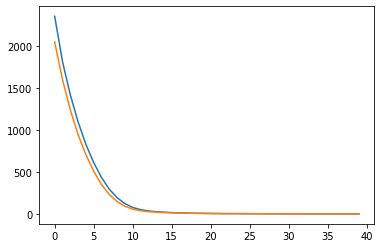

In [70]:
plt.plot(np.arange(len(history.history.get('loss'))),history.history.get('loss'))
plt.plot(np.arange(len(history.history.get('val_loss'))),history.history.get('val_loss'))
print(history.history.get('val_loss')[-5:])
plt.show()

In [71]:
xtest, ytest = get_train_data(data_folder='TestData')

In [72]:
model.evaluate(xtest,ytest)

353/353 [==============================] - 1s 2ms/step - loss: 4.3680


4.3680419921875

In [73]:
np.abs(model.predict(xtest[4][np.newaxis,:]) - ytest[4])

1/1 [==============================] - 0s 309ms/step


array([[0.28958541, 0.16807122, 0.48101159, 0.56678768, 0.24032066,
        0.71549932]])

In [74]:
model.predict(xtest[1][np.newaxis,:])

1/1 [==============================] - 0s 14ms/step


array([[-99.40815  , -99.313324 ,   4.6272078,  -4.9667134,   1.9575894,
         -3.4003925]], dtype=float32)

In [75]:
ytest[1][np.newaxis,:]

array([[-99.6280526 , -99.37938834,   2.84351576,  -5.2223954 ,
          2.15684655,  -3.6659816 ]])

In [77]:
model.save('lera_super.h5')
del model

In [78]:
from keras.models import load_model

m = load_model('lera_super.h5')

In [79]:
np.abs(m.predict(xtest[4][np.newaxis,:]) - ytest[4])

1/1 [==============================] - 0s 381ms/step


array([[0.28958541, 0.16807122, 0.48101159, 0.56678768, 0.24032066,
        0.71549932]])

In [51]:
# xtest[4][np.newaxis,:]

In [44]:
# ytest